SO what did I learn from this?


1. I have to double check, but it seems like if you have a 3sd move on open to close, then it almost always has a mean reversion move. I have to triple check this.
2. MonteCarlo simulation, when pulling from a distrobution is not too helpful if your distrobution's mean is centered above 0. What is more helpful is finding betting strategies or spotting situations when to not be in a trade.
3. So basically filtering, using machine learning, on cases where it might not be a good idea to take the trade.
4. Also now it might be time to figure out optimized betting strategies for after a mean reversion.
    a. So say you are after the initial SD move, what is the behavior of the 4 minutes after that help improve predictive power?
        i.  Something like that can be made programmatically.
        ii. Also this is anonolly detection to extent
        iii. I am curious if the model has carry over to other asset classes?
        iv. Probably best to automate this for each asset class.


I think I would need to change. Notebooks to do this otherwise it is too much for one notebook

In [1]:
import numpy as np
import random
from scipy.stats import cauchy
from scipy.stats import norm
from scipy.stats import laplace
import matplotlib.pyplot as plt 

from collections import defaultdict
import requests
from time import sleep
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
from datetime import datetime, timedelta, time
from urllib.error import HTTPError
import statistics

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#
cur_working_directiory = os.getcwd()
# Change 
os.chdir("../../../../Data/")


CSVfiles = []
for file in os.listdir("./"):
  if file.endswith(".csv"):
    CSVfiles.append(file)
print(CSVfiles)


unixTimeConverter = lambda x : (datetime.fromtimestamp(x)).strftime('%Y-%m-%d %H:%M:%S')
unixTimeConverterNoDateJustTime = lambda x: (datetime.fromtimestamp(x) - timedelta(hours=4)).time()


allDfs = []


for x in CSVfiles:

  dfTemp = pd.read_csv(x)
  dfTemp['estTime']  = dfTemp['time'].apply(unixTimeConverter)
  dfTemp['timeOnly'] = dfTemp['time'].apply(unixTimeConverterNoDateJustTime)

  dfTemp['candleHeight']  = dfTemp.apply( lambda row:    max(row['open'],  row['close']) - min(row['open'],  row['close']), axis = 1 )
  allDfs.append(dfTemp)

df = allDfs[0]
#This is for generating if profit
for i in range(1, 15):
  df['P/L' +str(i) +'Short_']  = ( df['close'] - df['close'].shift(-i) )
  df['P/L' +str(i) +'Long_']  =  (  df['close'].shift(-i) - df['close']     )
  df['P/L' +str(i) +'Short']  = ( df['close'] - df['close'].shift(i) )
  df['P/L' +str(i) +'Long']  =  (  df['close'].shift(i) - df['close']     )

df = df.tail(-15)


os.chdir(cur_working_directiory)
print(df.shape)
df.head()

d_counts_average_vol            = defaultdict(list)
d_counts_average_highLow_diff   = defaultdict(list)


closeOpenDeltaList = []
closeOpenDeltaList_ = []
openLowDeltaList = []
highLowDeltaList = []

for index, row in df.iterrows():
  closeOpenDeltaList.append(abs(row['close'] - row['open']))
  closeOpenDeltaList_.append(row['close'] - row['open'])
  openLowDeltaList.append(abs(row['open'] - row['low']))
  highLowDeltaList.append(row['high'] - row['low'])


df1 = pd.DataFrame({'closeOpenDelta': closeOpenDeltaList, 'CloseOpenDelta_': closeOpenDeltaList_, 'openLowDelta': openLowDeltaList, 'highLowDelta': highLowDeltaList})


# df2 = pd.concat([df, df1])

df2 = pd.concat([df.reset_index(drop=True), df1.reset_index(drop=True)], axis=1)

df2['PastCloseOpenDelta_'] = df2['CloseOpenDelta_'].shift(1)


print("mnath should add up")
print(df.shape)
print(df1.shape)
print(df2.shape)
df= df2

for index, row in df.iterrows():
  #put volumes in d
  time_  = str(row['timeOnly'])
  volume = row['Volume']
  d_counts_average_vol[str(time_)].append(volume)


  #Collecting, using a dictionary of lists to collect the price deltas for each time
  price_delta = row['closeOpenDelta']
  d_counts_average_highLow_diff[str(time_)].append(price_delta)

df.head()

###############################################
##THIS use to be seperate cells, but now I just combined them
##
################################################
import statistics

std_values_with_time_as_keys = {}
mean_values_with_time_as_keys = {}

#for volume
std_values_with_time_as_keys_volume = {}
mean_values_with_time_as_keys_volume = {}

for k , v in d_counts_average_highLow_diff.items():

  # Calculate mean and standard deviation of the sample for price delta
  mean = statistics.mean(v)
  std_dev = statistics.stdev(v)
  std_values_with_time_as_keys[k] = std_dev
  mean_values_with_time_as_keys[k] = mean

for k , v in d_counts_average_vol.items():
  # Calculate mean and standard deviation of the sample of volume
  mean__ = statistics.mean(v)
  std_dev__ = statistics.stdev(v)
  std_values_with_time_as_keys_volume[k] = std_dev__
  mean_values_with_time_as_keys_volume[k] = mean__


z_score_list = []
z_score_volume_list = []

for index, row in df.iterrows():
  time_  = str(row['timeOnly'])
  mean_ = mean_values_with_time_as_keys[time_]
  std_ = std_values_with_time_as_keys[time_]

  cur_val = row['closeOpenDelta']
  z_score_list.append(( cur_val - mean)/ std_)
  # row['z-score'] = (row['closeOpenDelta'] - mean)/ std_
  
  mean_ = mean_values_with_time_as_keys_volume[time_]
  std_ = std_values_with_time_as_keys_volume[time_]
  z_score_volume_list.append((row['Volume'] - mean)/ std_)

df['z-score']= z_score_list 
df['z-score-volume']= z_score_volume_list
df['past_z-score'] = df['z-score'].shift(1)
df['past_z-score-volume'] = df['z-score-volume'].shift(1)

df = df.tail(-1)



df.head(1)


['OANDA EURUSD, 5(2).csv', 'BATS AAPL, 30.csv', 'OANDA EURUSD, 240(1).csv', 'OANDA EURUSD, 60(3).csv', 'OANDA EURUSD, 30(4).csv']
(16764, 66)
mnath should add up
(16764, 66)
(16764, 4)
(16764, 71)


,time,open,high,low,close,Volume,Volume MA,estTime,timeOnly,candleHeight,...,P/L14Long,closeOpenDelta,CloseOpenDelta_,openLowDelta,highLowDelta,PastCloseOpenDelta_,z-score,z-score-volume,past_z-score,past_z-score-volume
1,1681400400,1.10572,1.10594,1.10572,1.1058,350,503.6,2023-04-13 11:40:00,07:40:00,0.00008,...,0.0,0.00008,0.00008,0.0,0.00022,0.00044,-0.838964,2.460497,1.154801,2.209367


0        NaN
1    0.00044
2    0.00008
3    0.00020
4   -0.00078
Name: CloseOpenDelta_, dtype: float64

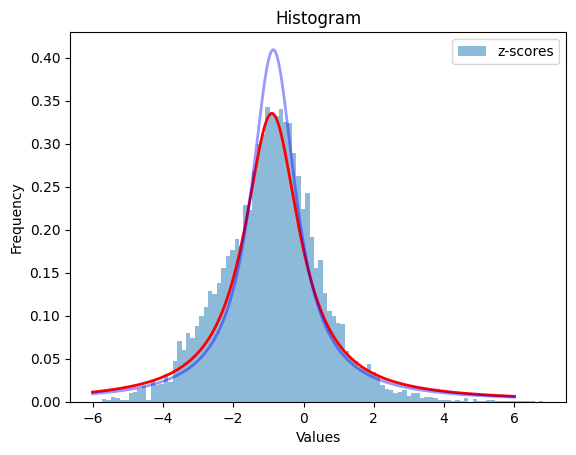

In [4]:

fig, ax = plt.subplots(1, 1)

#I need all the z-scores
ax.hist(z_score_list, bins=100, alpha=0.5, label='z-scores', stacked=True, density=True)

# Add a legend, title, and labels to the plot
plt.legend()
plt.title('Histogram')
plt.xlabel('Values')
plt.ylabel('Frequency')

#Me trying to fit the distrobiution manually
rv = cauchy(-0.9, 0.95)
x = np.linspace(-6,6, 1000) 
ax.plot(x, rv.pdf(x),  'r-',  lw=2, alpha=0.4, label='cauchy pdf')

#What scipy thinks the distribution is
a, b = cauchy.fit(z_score_list)
rv = cauchy(a,b)
x = np.linspace(-6,6, 1000) 
ax.plot(x, rv.pdf(x),  'b-',  lw=2, alpha=0.4, label='cauchy pdf')



# Show the plot
plt.show()

#This is not the data set 


So the above is not the data set I want to fit, but it is not a bad example.
Cauchy obviously is a little too fat tailed.
But I think I can mix distrobiton models out so that they average out to something more appropiate

Now I need to do the style of operation, but on something useful that I can test.

The data I should use.
The z-score of the time after 3-sd moves
So then I can make a distrobution from that?
z-score fo that.

z_score_of_time_after_list length list [1.805389469442073, 2.0978873879630227, 0.2997987055849934, -0.6379361665380751, 1.9380544563872004, 4.627467447020908, 0.25455483165341797, -0.607833424590679, -0.34571486491817527, 3.3339805947046446, -1.2301385747017008, -0.26923856076681324, 1.2075721004195272, 2.030136582017171, -0.3348199270512886, 1.3882309244454583, 0.8870833203042068, 0.011157525064103148, -0.48015284458116847, 0.06325384150786031, -0.9756369723741926, 1.908470150082492, 2.365700311538239, 5.149960109979452, 1.9303032022880833, 4.6099702066773265, 1.4533610766473335, -2.072787506623338, 0.9547184866460064, 1.3523634366661632, 5.215557059728459, 2.2378963780246415, 1.3299959544189048, -2.0354407640439924, 1.8793714581997716, -0.4057768811387854, 1.811673705708796, -0.23398181840239238, 6.462120383634665, 2.180489302610216, -0.6776238538728674, 0.24959748733791226, 2.122369207291545, 2.6903717502151485, 0.2612182549727933, 2.0487214149965514, -3.1938935173010923, -0.2400227

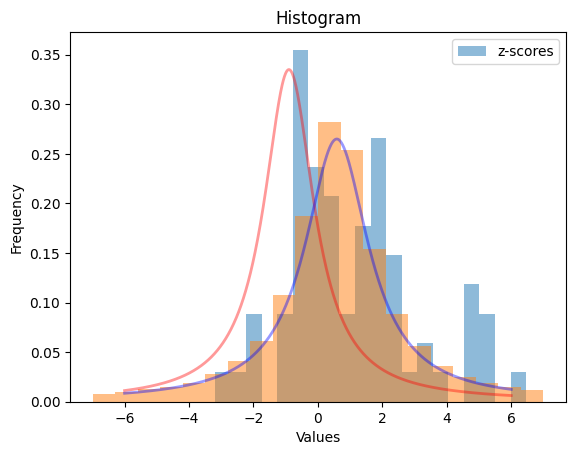

mu 2.499999999999249e-05
sd 0.0006791207550944028
gainFrom 34.27898873841847
mu 0.0011495714285714197
sd 0.0006056270321252129
gainFrom 131.03339795153087


In [2]:
import scipy as stats

#z-score of the time after 3sd
z_score_of_time_after_list = []
price_delta_of_time_after_list = []

def getZScoreOfTimeAfter(i, z_score_ = 3):
  price_delta_of_time_after_list___ = []
  for index, row in df.iterrows():
    if row['z-score'] > z_score_ and  row['CloseOpenDelta_'] > 0:
#       z_score_of_time_after_list.append(df.loc[index+1, 'z-score'])
#       price_delta_of_time_after_list.append(df.loc[index+1, row['CloseOpenDelta_']])
#       # price_delta_of_time_after_list___.append(df.loc[index+1, 'CloseOpenDelta_'])
      price_delta_of_time_after_list___.append(row['P/L' +str(i) +'Short'])
  return price_delta_of_time_after_list___


price_delta_moves = getZScoreOfTimeAfter(1)

for index, row in df.iterrows():
    if row['z-score'] > 3 and  row['CloseOpenDelta_'] > 0:
        z_score_of_time_after_list.append(df.loc[index+1, 'z-score'])
        price_delta_of_time_after_list.append(df.loc[index+1, 'CloseOpenDelta_'])



fig, ax = plt.subplots(1, 1)

print("z_score_of_time_after_list length list", z_score_of_time_after_list)

#I need all the z-scores
ax.hist(z_score_of_time_after_list, bins=20, alpha=0.5, label='z-scores', stacked=True, density=True)

# Add a legend, title, and labels to the plot
plt.legend()
plt.title('Histogram')
plt.xlabel('Values')
plt.ylabel('Frequency')

#Me trying to fit the distrobiution manually
rv = cauchy(-0.9, 0.95)
x = np.linspace(-6,6, 1000) 
ax.plot(x, rv.pdf(x),  'r-',  lw=2, alpha=0.4, label='cauchy pdf')

#What scipy thinks the distribution is
a, b = cauchy.fit(z_score_of_time_after_list)
rv = cauchy(a,b)
x = np.linspace(-6,6, 1000) 
ax.plot(x, rv.pdf(x),  'b-',  lw=2, alpha=0.4, label='cauchy pdf')


monteCarlos1 = cauchy.rvs(loc=a, scale=b, size=100000, random_state=None)
monteCarlos1 = [thisX for thisX in monteCarlos1 if thisX > -7 and thisX < 7] 



#I need all the z-scores
ax.hist(monteCarlos1 ,  bins=20, alpha=0.5,  label='g-scores', stacked=True, density=True)


# Show the plot
plt.show()

#This maybe bad math, but I am gonna try
# (value - mean / std) = z-score
# so (value - mean) = z-score * std
# so (value - mean) + mean = z-score * std + mean
# so value  = (z-score * std) + mean

#z_score_of_time_after_list

standard_deviation = np.std(price_delta_of_time_after_list)
mu                 = np.mean(price_delta_of_time_after_list)

print("mu", mu)
print("sd", standard_deviation)

ls_of_scores = [ (standard_deviation* z_score) + mu  for z_score in  monteCarlos1]

gainFrom = sum(ls_of_scores)
print("gainFrom", gainFrom)





standard_deviation = np.std(price_delta_moves)
mu                 = np.mean(price_delta_moves)

print("mu", mu)
print("sd", standard_deviation)

ls_of_scores = [ (standard_deviation* z_score) + mu  for z_score in  monteCarlos1]

gainFrom = sum(ls_of_scores)
print("gainFrom", gainFrom)



In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


X = []
Y = []


basics = []

for index, row in df.iterrows():
    if row['z-score'] > 3 and  row['CloseOpenDelta_'] > 0:
        row_to_append = [row['z-score'], row['z-score-volume'], row['past_z-score'], row['past_z-score-volume'], row['timeOnly'].hour ]
        X.append(row_to_append)
        basics.append(row['P/L' +str(4) +'Short'])
        if row['P/L' +str(4) +'Short'] < 0:
            
            Y.append(1)
        else:
            Y.append(0)

print("X length", len(X))
print("Y sumh", sum(Y))

# Split the data into training and testing sets (e.g., 80% for training and 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


print("---------------------")
print("basics length", len(basics))
print("basics mean", np.mean(basics))
print("basics std", np.std(basics))
print("basics min", min(basics))
print("basics max", max(basics))

X length 70
Y sumh 5
Accuracy: 0.9285714285714286
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       0.00      0.00      0.00         1

    accuracy                           0.93        14
   macro avg       0.46      0.50      0.48        14
weighted avg       0.86      0.93      0.89        14

Confusion Matrix:
[[13  0]
 [ 1  0]]
---------------------
basics length 70
basics mean 0.0011325714285714257
basics std 0.0011016412246076847
basics min -0.0026000000000001577
basics max 0.0041799999999998505


/home/garrett/anaconda3/envs/gmoney/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/garrett/anaconda3/envs/gmoney/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/garrett/anaconda3/envs/gmoney/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

This is using SMOTE for the first time in a long time.

In [18]:


import numpy as np
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE


X = []
Y = []


basics = []

for index, row in df.iterrows():
    if row['z-score'] > 3 and  row['CloseOpenDelta_'] > 0:
        row_to_append = [row['z-score'], row['z-score-volume'], row['past_z-score'], row['past_z-score-volume'], row['timeOnly'].hour ]
        X.append(row_to_append)
        basics.append(row['P/L' +str(4) +'Short'])
        if row['P/L' +str(4) +'Short'] < 0:
            
            Y.append(1)
        else:
            Y.append(0)
for index, row in df.iterrows():
    if row['z-score'] > 3 and  row['CloseOpenDelta_'] > 0:
        row_to_append = [row['z-score'], row['z-score-volume'], row['past_z-score'], row['past_z-score-volume'], row['timeOnly'].hour ]
        X.append(row_to_append)
        basics.append(row['P/L' +str(4) +'Short'])
        if row['P/L' +str(4) +'Short'] < 0:
            
            Y.append(1)
        else:
            Y.append(0)



print("X length", len(X))
print("Y len", len(Y))
print("Y sum", sum(Y))

X = np.array(X)
Y = np.array(Y)



# Before applying SMOTE: count the number of samples in each class
print("Before SMOTE:")
print("Class 0 samples:", np.sum(Y == 0))
print("Class 1 samples:", np.sum(Y == 1))

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, Y)

# After applying SMOTE: count the number of samples in each class
print("After SMOTE:")
print("Class 0 samples:", np.sum(y_resampled == 0))
print("Class 1 samples:", np.sum(y_resampled == 1))


X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Create the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)



X length 140
Y len 140
Y sum 10
Before SMOTE:
Class 0 samples: 130
Class 1 samples: 10
After SMOTE:
Class 0 samples: 130
Class 1 samples: 130
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        30

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52

Confusion Matrix:
[[22  0]
 [ 0 30]]
